In [50]:
import pandas as pd
import numpy as np

In [51]:
df = pd.read_pickle("../data/processed/merged_data.pkl")

In [58]:

print(df.columns.tolist())

['datetime', 'open', 'high', 'low', 'close', 'volume', 'merge_date', 'avg_sentiment_polarity', 'avg_sentiment_neg', 'avg_sentiment_neu', 'avg_sentiment_pos', 'daily_news_count', 'CAPEI', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'roa', 'roe', 'npm', 'ps', 'de_ratio', 'avg_sentiment_polarity_lag1d', 'avg_sentiment_neg_lag1d', 'avg_sentiment_neu_lag1d', 'avg_sentiment_pos_lag1d', 'daily_news_count_lag1d']


In [53]:
df = df.copy()
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce', utc=True)
df['datetime'] = df['datetime'].dt.tz_convert('America/New_York')  # 转为美东时间
df = df.sort_values('datetime')


In [54]:
# 日历键：同一天里盘前/日盘/盘后都映射到同一 merge_date
df['merge_date'] = df['datetime'].dt.normalize()

In [55]:
# 可能存在的新闻列（按你表实际自动识别）
sa_cols = [c for c in ['avg_sentiment_polarity','avg_sentiment_neg','avg_sentiment_neu',
                       'avg_sentiment_pos','daily_news_count'] if c in df.columns]

if sa_cols:
    # 先做“按天唯一”的新闻表（你原表里这些列同一天通常相同）
    day_sa = (df.groupby('merge_date')[sa_cols]
                .first()       # 当日一条
                .sort_index())
    # T+1：今天看的是昨天的新闻
    day_sa_lag = day_sa.shift(1).add_suffix('_lag1d')

    # 合回分钟级
    df = df.merge(day_sa_lag, left_on='merge_date', right_index=True, how='left')


In [56]:
df

,datetime,open,high,low,close,volume,merge_date,avg_sentiment_polarity,avg_sentiment_neg,avg_sentiment_neu,...,roa,roe,npm,ps,de_ratio,avg_sentiment_polarity_lag1d,avg_sentiment_neg_lag1d,avg_sentiment_neu_lag1d,avg_sentiment_pos_lag1d,daily_news_count_lag1d
0,2018-11-30 12:50:00-05:00,44.60,44.64,44.55,44.63,179494,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
1,2018-11-30 12:55:00-05:00,44.63,44.63,44.52,44.52,218881,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
2,2018-11-30 13:00:00-05:00,44.52,44.55,44.44,44.49,364114,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
3,2018-11-30 13:05:00-05:00,44.49,44.52,44.44,44.46,251652,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
4,2018-11-30 13:10:00-05:00,44.45,44.51,44.44,44.45,200756,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104023,2024-03-13 18:40:00-04:00,171.47,171.65,171.47,171.60,515713,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104024,2024-03-13 18:45:00-04:00,171.59,171.71,171.50,171.66,566382,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104025,2024-03-13 18:50:00-04:00,171.65,171.65,171.19,171.29,869695,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104026,2024-03-13 18:55:00-04:00,171.30,171.30,171.04,171.15,1413942,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0


In [48]:
fa_cols = [c for c in ['CAPEI','bm','evm','pe_op_basic','pe_op_dil','roa','roe','npm','ps','de_ratio']
           if c in df.columns]

if fa_cols:
    # 1) 日级披露表
    fa_day = (df[['merge_date'] + fa_cols]
              .drop_duplicates('merge_date')
              .dropna(subset=fa_cols, how='all')
              .set_index('merge_date')
              .sort_index())

    # 2) 披露+45天可见
    fa_visible = fa_day.copy()
    fa_visible.index = fa_visible.index + pd.Timedelta(days=45)
    fa_visible.index.name = 'visible_from'

    # 3) 交易日日轴（保留时区，不要 .values）
    trade_days = (df[['merge_date']].drop_duplicates()
                  .sort_values('merge_date')
                  .rename(columns={'merge_date':'trade_date'}))

    right = fa_visible.reset_index().rename(columns={'visible_from':'trade_date'})
    fa_asof = pd.merge_asof(
        trade_days.sort_values('trade_date'),
        right.sort_values('trade_date'),
        on='trade_date', direction='backward'
    )

    # 🔧 关键：先把旧的基本面列删掉，避免后缀
    df = df.drop(columns=[c for c in fa_cols if c in df.columns])

    # 4) 合并回分钟级
    df = (df.merge(fa_asof, left_on='merge_date', right_on='trade_date', how='left')
            .drop(columns=['trade_date'])
            .sort_values(['merge_date','datetime']))

    # 5) 日内前向填充
    df[fa_cols] = df.groupby('merge_date')[fa_cols].ffill()



In [57]:
df

,datetime,open,high,low,close,volume,merge_date,avg_sentiment_polarity,avg_sentiment_neg,avg_sentiment_neu,...,roa,roe,npm,ps,de_ratio,avg_sentiment_polarity_lag1d,avg_sentiment_neg_lag1d,avg_sentiment_neu_lag1d,avg_sentiment_pos_lag1d,daily_news_count_lag1d
0,2018-11-30 12:50:00-05:00,44.60,44.64,44.55,44.63,179494,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
1,2018-11-30 12:55:00-05:00,44.63,44.63,44.52,44.52,218881,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
2,2018-11-30 13:00:00-05:00,44.52,44.55,44.44,44.49,364114,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
3,2018-11-30 13:05:00-05:00,44.49,44.52,44.44,44.46,251652,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
4,2018-11-30 13:10:00-05:00,44.45,44.51,44.44,44.45,200756,2018-11-30 00:00:00-05:00,0.998000,0.009000,0.925,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104023,2024-03-13 18:40:00-04:00,171.47,171.65,171.47,171.60,515713,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104024,2024-03-13 18:45:00-04:00,171.59,171.71,171.50,171.66,566382,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104025,2024-03-13 18:50:00-04:00,171.65,171.65,171.19,171.29,869695,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104026,2024-03-13 18:55:00-04:00,171.30,171.30,171.04,171.15,1413942,2024-03-13 00:00:00-04:00,0.552455,0.027727,0.844,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0


In [59]:
def pct(x): return f"{100*x:.1f}%"
print("Rows:", len(df))

if sa_cols:
    lag_cols = [f'{c}_lag1d' for c in sa_cols if f'{c}_lag1d' in df.columns]
    print("News (lag1d) coverage:", pct(df[lag_cols].notna().any(axis=1).mean()))

if fa_cols:
    print("Fundamentals coverage:", pct(df[fa_cols].notna().any(axis=1).mean()))

# 看某一天的几行，确认用的是“前一日”的新闻
if sa_cols:
    day_example = df['merge_date'].dropna().unique()[5]
    print(df[df['merge_date']==day_example][['datetime'] + lag_cols].head(3))


Rows: 104028
News (lag1d) coverage: 71.3%
                     datetime  avg_sentiment_polarity_lag1d  \
374 2018-12-10 11:30:00-05:00                           NaN   
375 2018-12-10 11:35:00-05:00                           NaN   
376 2018-12-10 11:40:00-05:00                           NaN   

     avg_sentiment_neg_lag1d  avg_sentiment_neu_lag1d  \
374                      NaN                      NaN   
375                      NaN                      NaN   
376                      NaN                      NaN   

     avg_sentiment_pos_lag1d  daily_news_count_lag1d  
374                      NaN                     NaN  
375                      NaN                     NaN  
376                      NaN                     NaN  


In [60]:
df.to_csv('merged_full_debug.csv', index=False)

In [61]:
drop_cols = [
    'avg_sentiment_polarity', 
    'avg_sentiment_neg', 
    'avg_sentiment_neu', 
    'avg_sentiment_pos', 
    'daily_news_count'
]

df = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [62]:
df

,datetime,open,high,low,close,volume,merge_date,CAPEI,bm,evm,...,roa,roe,npm,ps,de_ratio,avg_sentiment_polarity_lag1d,avg_sentiment_neg_lag1d,avg_sentiment_neu_lag1d,avg_sentiment_pos_lag1d,daily_news_count_lag1d
0,2018-11-30 12:50:00-05:00,44.60,44.64,44.55,44.63,179494,2018-11-30 00:00:00-05:00,17.191,0.1,14.855,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
1,2018-11-30 12:55:00-05:00,44.63,44.63,44.52,44.52,218881,2018-11-30 00:00:00-05:00,17.191,0.1,14.855,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
2,2018-11-30 13:00:00-05:00,44.52,44.55,44.44,44.49,364114,2018-11-30 00:00:00-05:00,17.191,0.1,14.855,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
3,2018-11-30 13:05:00-05:00,44.49,44.52,44.44,44.46,251652,2018-11-30 00:00:00-05:00,17.191,0.1,14.855,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
4,2018-11-30 13:10:00-05:00,44.45,44.51,44.44,44.45,200756,2018-11-30 00:00:00-05:00,17.191,0.1,14.855,...,0.216,0.436,0.224,3.194,2.413,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104023,2024-03-13 18:40:00-04:00,171.47,171.65,171.47,171.60,515713,2024-03-13 00:00:00-04:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104024,2024-03-13 18:45:00-04:00,171.59,171.71,171.50,171.66,566382,2024-03-13 00:00:00-04:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104025,2024-03-13 18:50:00-04:00,171.65,171.65,171.19,171.29,869695,2024-03-13 00:00:00-04:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0
104026,2024-03-13 18:55:00-04:00,171.30,171.30,171.04,171.15,1413942,2024-03-13 00:00:00-04:00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.369,0.034615,0.843385,0.122077,13.0


In [70]:

from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold

# 你已有 df：包含 datetime、merge_date、价格、量、新闻_lag1d、基本面(as-of) 等
df_feat = df.copy()

# 0) 明确不可用列（时间键 & 当日新闻，避免泄漏）
drop_leak = [
    'datetime', 'merge_date',
    'avg_sentiment_polarity', 'avg_sentiment_neg', 'avg_sentiment_neu',
    'avg_sentiment_pos', 'daily_news_count'  # 仅保留 *_lag1d 版本
]
present_drop = [c for c in drop_leak if c in df_feat.columns]
df_feat = df_feat.drop(columns=present_drop)

# 1) 选择初始候选（数值列）
num_cols = df_feat.select_dtypes(include=[np.number]).columns.tolist()

# 2) 覆盖率过滤（默认保留缺失率<=30%）
min_coverage = 0.70
cov = df_feat[num_cols].notna().mean().sort_values(ascending=False)
keep_cov = cov[cov >= min_coverage].index.tolist()

# 3) 简单填补（仅用于后续方差/相关性计算，不改变原 df）
imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(df_feat[keep_cov]), columns=keep_cov, index=df_feat.index)

# 4) 低方差过滤（几乎常量）
vt = VarianceThreshold(threshold=1e-10)   # 很小阈值，过滤“近乎常量”
vt.fit(X_imp)
keep_var = [f for f, ok in zip(keep_cov, vt.get_support()) if ok]

# 5) 强相关去冗余（|corr|>0.95 只保留一个）
corr = X_imp[keep_var].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if (upper[col] > 0.95).any()]
keep_corr = [c for c in keep_var if c not in to_drop]

# 6) VIF 过滤（多重共线性，VIF>=10 的先剔除）
try:
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    Xv = X_imp[keep_corr].copy()
    # 逐步剔除高VIF
    vif_keep = keep_corr[:]
    while True:
        if len(vif_keep) <= 2:
            break
        Xv_sub = Xv[vif_keep].values
        vifs = [variance_inflation_factor(Xv_sub, i) for i in range(Xv_sub.shape[1])]
        vmax = float(np.max(vifs))
        if vmax < 10:
            break
        worst = vif_keep[int(np.argmax(vifs))]
        vif_keep.remove(worst)
    final_candidates = vif_keep
except Exception:
    # 没装 statsmodels 时退化到仅相关性过滤的结果
    final_candidates = keep_corr

print(f"起始特征: {len(num_cols)}")
print(f"覆盖率>=70%: {len(keep_cov)}")
print(f"低方差过滤后: {len(keep_var)}")
print(f"相关性去冗余后: {len(keep_corr)}")
print(f"VIF控制后(最终候选): {len(final_candidates)}")
print("最终候选示例前20个：", final_candidates[:20])

起始特征: 20
覆盖率>=70%: 10
低方差过滤后: 10
相关性去冗余后: 7
VIF控制后(最终候选): 5
最终候选示例前20个： ['open', 'volume', 'avg_sentiment_neg_lag1d', 'avg_sentiment_polarity_lag1d', 'daily_news_count_lag1d']


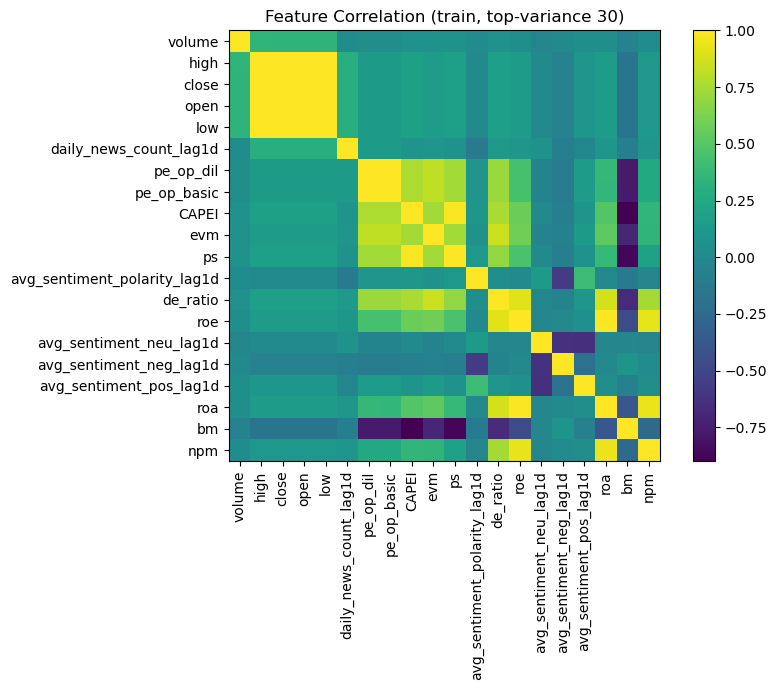

In [71]:

import matplotlib.pyplot as plt

# 仅数值特征；排除时间键/目标/当日新闻（保留 *_lag1d）
ignore = {'datetime','merge_date','y_next',
          'avg_sentiment_polarity','avg_sentiment_neg','avg_sentiment_neu','avg_sentiment_pos','daily_news_count'}
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c not in ignore]

# （可选）只在训练集做
q1 = df['datetime'].quantile(0.70)
train = df[df['datetime'] <= q1]

X = train[num_cols].copy()
X = X.fillna(X.median())   # 只为画图临时补缺
# 为了可读性，挑方差Top30列
var30 = X.var().sort_values(ascending=False).head(30).index
corr = X[var30].corr()

plt.figure(figsize=(9,7))
plt.imshow(corr.values, interpolation='nearest')
plt.xticks(range(len(var30)), var30, rotation=90)
plt.yticks(range(len(var30)), var30)
plt.title("Feature Correlation (train, top-variance 30)")
plt.colorbar()
plt.tight_layout()
plt.show()


In [75]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

fa_cols = [c for c in fa_all if c in df.columns]
q1, q2 = df['datetime'].quantile([0.70, 0.85])
train_idx = df['datetime'] <= q1
valid_idx = (df['datetime'] > q1) & (df['datetime'] <= q2)
test_idx  = df['datetime'] > q2

# 1) 以 train 段覆盖率选 Top-k（k=1~3）
cov_tr = df.loc[train_idx, fa_cols].notna().mean().sort_values(ascending=False)
fa_pick = cov_tr[cov_tr > 0].index.tolist()[:3]   # 至少有非空就拿
print("FA-lite 使用的列：", fa_pick)

if len(fa_pick) == 0:
    print("train 段里基本面完全空 → 暂时跳过FA，后续可延后起点或只做 sentiment+价量。")
else:
    # 2) 缺失指示
    for c in fa_pick:
        df[f'{c}_isna'] = df[c].isna().astype('int8')

    # 3) 年龄（距离最近一次披露的天数，已是 as-of 后按天广播）
    #   先按天聚合再向后填充，保证年龄单调增加
    day_any = df.groupby('merge_date')[fa_pick].apply(lambda x: x.notna().any().any()).astype(int)
    day_age = (day_any.groupby((day_any==1).cumsum())
                      .apply(lambda s: (s.index - s.index.min()).days)
               ).reindex(df['merge_date']).values
    df['fa_age_days'] = np.clip(np.nan_to_num(day_age, nan=365), 0, 365).astype('int16')

    # 4) 在 train 上拟合“中位数填补+标准化”，得到 z 分数
    imp = SimpleImputer(strategy='median')
    sc  = StandardScaler()

    Xtr = df.loc[train_idx, fa_pick]
    Xva = df.loc[valid_idx, fa_pick]
    Xte = df.loc[test_idx,  fa_pick]

    Ztr = sc.fit_transform(imp.fit_transform(Xtr))
    Zva = sc.transform(imp.transform(Xva))
    Zte = sc.transform(imp.transform(Xte))

    z_cols = [f'{c}_z' for c in fa_pick]
    df.loc[train_idx, z_cols] = Ztr
    df.loc[valid_idx, z_cols] = Zva
    df.loc[test_idx,  z_cols] = Zte

    # 5) 组合一个“FA综合分”（有值就取均值，无值跳过）
    df['fa_composite_z'] = df[z_cols].mean(axis=1, skipna=True)


FA-lite 使用的列： ['CAPEI', 'bm', 'evm']
